In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import qutip as q
import numpy as np 
import scipy.linalg as la

In [567]:
import qutip as q
import numpy as np

T2 = 50e-6
T1 = 100e-6

xm, xp = q.sigmax().eigenstates()[1]
xp, xm = xp * xp.dag(), xm * xm.dag()
ym, yp = q.sigmay().eigenstates()[1]
yp, ym = yp * yp.dag(), ym * ym.dag()
zp, zm = q.sigmaz().eigenstates()[1]
zm, zp = zp * zp.dag(), zm * zm.dag()

hada = q.qeye(2) # 1/np.sqrt(2) * q.Qobj([[1,1], [1,-1]])
init_states = [hada * dm * hada for dm in [xp, xm, yp, ym, zp, zm]]

delta = (CONST['gamma_e'] * 2e-6)
H = q.Qobj([[0,0], [0,delta]])
c_ops = [np.sqrt(1/(2*T2)) * q.sigmaz()] # , np.sqrt(1/T1) * q.sigmap()]
times = np.linspace(0, 50e-6, 500)

states = []
for init_state in init_states:
    rho0 = init_state
    result = q.mesolve(H, rho0, times, c_ops).states
    result = [hada * dm * hada for dm in result]
    states.append(result)

pauli = True
if pauli:
    sigmax = np.array( [[q.expect(dm, q.sigmax()).real for dm in row] for row in states])
    sigmay = np.array( [[q.expect(dm, q.sigmay()).real for dm in row] for row in states])
    sigmaz = np.array( [[q.expect(dm, q.sigmaz()).real for dm in row] for row in states])
    miri_list = np.array([sigmax, sigmay, sigmaz])

else:
    pop0 = np.array( [[q.expect(dm, q.fock_dm(2, 0)).real for dm in row] for row in states] )
    pop1 = np.array( [[q.expect(dm, q.fock_dm(2, 1)).real for dm in row] for row in states] )
    miri_list = np.array([pop0, pop1])
    
miri_list = np.transpose(miri_list, (1, 0, 2))
np.save("Lindblad_test1.npy", miri_list)

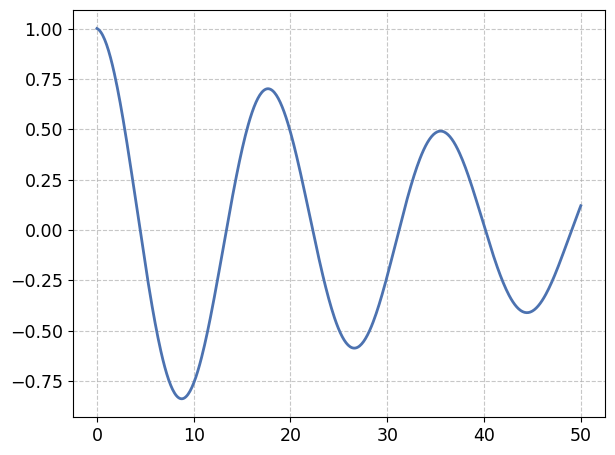

In [568]:
miri_list = np.load("Lindblad_test1.npy")
plt.plot(times*1e6, miri_list[0,0,:])

In [8]:
PAULIS = [q.qeye(2), q.sigmax(), q.sigmay(), q.sigmaz()]
MATRIX_UNITS = [np.array([[1,0], [0,0]]), 
               np.array([[0,0], [1,0]]),
               np.array([[0,1], [0,0]]),
               np.array([[0,0], [0,1]])
               ]

def construct_PTM(input_array):
    """ input_array 
        1st dimension: pauli eigenstates as initial states in order xp,xm,yp,ym,zp,zm.
        2nd dimension: pauli observables in order X, Y, Z.
        3rd dimension: timesteps. 
    """

    n_timesteps = input_array.shape[-1]
    PTM = np.zeros((4,4,n_timesteps))

    PTM[0,0,:] = 1 # first column is (1,0,0,0)
    for i in range(3):
        PTM[i+1,0,:] = 0.5 * (input_array[4,i,:] + input_array[5,i,:]) # identity
        PTM[i+1,1,:] = 0.5 * (input_array[0,i,:] - input_array[1,i,:]) # sigma_x
        PTM[i+1,2,:] = 0.5 * (input_array[2,i,:] - input_array[3,i,:]) # sigma_y
        PTM[i+1,3,:] = 0.5 * (input_array[4,i,:] - input_array[5,i,:]) # sigma_z
    return PTM 

def invert_PTM(PTM):
    PTM_inv = np.zeros((4, 4))
    PTM_inv[0, 0] = 1  # top-left stays 1

    t = PTM[1:, 0]
    R = PTM[1:, 1:] 
    R_inv = np.linalg.inv(R)
    t_inv = -np.dot(R_inv, t)
    
    PTM_inv[1:, 0] = t_inv
    PTM_inv[1:, 1:] = R_inv

    return PTM_inv

# ---------------------------

def rho_to_pauli_vec(rho):
    return 0.5 * np.array([np.trace(rho @ P.full()) for P in PAULIS]).T

def pauli_vec_to_rho(pauli_vec):
    return sum([c * P.full() for c, P in zip(pauli_vec, PAULIS)])

def rho_to_vec(rho):
    return np.array([rho[0,0], rho[1,0], rho[0,1], rho[1,1]]).T

def vec_to_rho(vec):
    return np.array([[vec[0], vec[2]], [vec[1], vec[3]]])

def apply_ptm(PTM, rho):
    pauli_vec_before = rho_to_pauli_vec(rho)
    pauli_vec_after = PTM @ pauli_vec_before
    rho = pauli_vec_to_rho(pauli_vec_after)
    return rho

def apply_choi(choi, rho):
    rho = rho[0,0] * choi[0:2, 0:2] + rho[1,0] * choi[2:4, 0:2] + rho[0,1] * choi[0:2, 2:4] + rho[1,1] * choi[2:4, 2:4]
    return rho

# ---------------------------

def pauli_matrix():    
    pauli_matrix = np.zeros((4,4), dtype=complex)
    for i, pauli in enumerate(PAULIS):
        pauli_matrix[:, i] = q.operator_to_vector(pauli).dag().full()
    return pauli_matrix

def TM_to_PTM(TM):
    B = pauli_matrix()/np.sqrt(2)
    return (B.conj().T @ TM @ B)

def PTM_to_TM(PTM):
    B = pauli_matrix()/np.sqrt(2)
    return (B @ PTM @ B.conj().T)

def PTM_to_Choi(PTM):
    Choi = np.zeros([4,4], dtype=complex)
    
    Choi[0:2,0:2] = apply_ptm(PTM, MATRIX_UNITS[0]) 
    Choi[2:4,0:2] = apply_ptm(PTM, MATRIX_UNITS[1])
    Choi[0:2,2:4] = apply_ptm(PTM, MATRIX_UNITS[2])
    Choi[2:4,2:4] = apply_ptm(PTM, MATRIX_UNITS[3])
    return Choi

def Choi_to_PTM(choi):
    PTM = np.zeros((4, 4), dtype=complex)

    rho_after = [apply_choi(choi, P) for P in PAULIS]

    for i, P in enumerate(PAULIS):
        for j, rho in enumerate(rho_after):
            PTM[i, j] = 0.5 * np.trace(P.full() @ rho)

    return PTM

In [529]:
def get_Choi_pm(choi):
    eigvals, eigvecs = np.linalg.eig(choi)
    projectors = [np.outer(v, v.conj()) for v in eigvecs.T]
    choi_plus = sum(max(0, ev.real) * P for ev, P in zip(eigvals, projectors))
    choi_minus = sum(max(0, -ev.real) * P for ev, P in zip(eigvals, projectors))
    if np.sum(np.abs(choi_minus)) != 0:
        reg = 0e-2 * sum(projectors)
        choi_plus += reg
        choi_minus += reg
    return choi_plus, choi_minus

def get_PTM_D(PTM_minus):
    kraus_sum = apply_ptm(PTM_minus, np.eye(2)) # apply map to identity. corresponds to the sum of Kraus operators 
    eigv, _ = np.linalg.eig(kraus_sum)
    p = max(eigv + 0e-2)
    D = la.sqrtm(p * np.eye(2) - kraus_sum)
    TM_D = q.sprepost(q.Qobj(D), q.Qobj(D)).full()
    PTM_D = TM_to_PTM(TM_D)
    return PTM_D, p 

def get_extremal_maps(PTM):
    Choi = PTM_to_Choi(PTM)

    # determine A, B, C matrices
    A = Choi[0:2, 0:2]
    B = Choi[2:4, 2:4]
    C = Choi[0:2, 2:4]

    # calculate contraction matrix R
    sqrtA = la.sqrtm(A)
    sqrtB = la.sqrtm(B)
    R = np.array([[0,1],[1,0]])# la.inv(sqrtA) @ C @ la.inv(sqrtB)
    
    u, s, vh = np.linalg.svd(R)
    s = np.round(s, 5)
    theta = np.arccos(s)
    D1 = np.diag(np.exp(1j * theta))
    D2 = np.diag(np.exp(-1j * theta))

    # Create Choi1
    Choi1 = Choi.copy()
    Choi1[0:2, 2:4] = sqrtA @ u @ D1 @ vh @ sqrtB
    Choi1[2:4, 0:2] = sqrtB @ vh.conj().T @ D2 @ u.conj().T @ sqrtA

    # Create Choi2
    Choi2 = Choi.copy()
    Choi2[0:2, 2:4] = sqrtA @ u @ D2 @ vh @ sqrtB
    Choi2[2:4, 0:2] = sqrtB @ vh.conj().T @ D1 @ u.conj().T @ sqrtA

    return [Choi1, Choi2]

def adjChoi_to_Choi(choi):
    # eq. (25) of Ruskai2002           
    U23 = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    adj_choi = np.conjugate(U23 @ choi @ U23)
    return adj_choi

from scipy.spatial.transform import Rotation as R

def unitary_to_rotation(unitary):
    return # TODO

def rotation_to_unitary(rotation):
    rotvec = R.from_matrix(rotation.real).as_rotvec() # angle * rotation axis
    generator = -1j / 2 * sum(r * P for r, P in zip(rotvec, PAULIS[1:]))
    return generator.expm()

def get_extremal_map(circuit_input):
    U1, U2, mu, nu = circuit_input
    T = np.array()
    return extremal_map

def get_circuit_input(choi):
    adj_choi = adjChoi_to_Choi(choi)
    PTM = Choi_to_PTM(adj_choi)
    T = PTM[1:4, 1:4]
    t = PTM[1:4, 0]
    uu, ss, vvh = np.linalg.svd(T, full_matrices=True)
    U1 = rotation_to_unitary(np.linalg.det(uu)*uu)
    U2 = rotation_to_unitary(np.linalg.det(vvh)*vvh)

    # Compute rotation parameters (cosine of angles)
    sign_det = np.linalg.det(uu) * np.linalg.det(vvh)
    cos_theta1 = sign_det * ss[0]
    cos_theta2 = sign_det * ss[0]
    cos_theta3 = sign_det * ss[1]
    
    # Clamp to avoid numerical issues (|cos(θ)| ≤ 1)
    cos_theta1 = onemax(cos_theta1)
    cos_theta2 = onemax(cos_theta2)
    cos_theta3 = onemax(cos_theta3)
    
    # Compute sign sigma based on sine terms and a directional component
    sin1 = np.sin(np.arccos(cos_theta1))
    sin3 = np.sin(np.arccos(cos_theta3))
    vec = np.dot(np.linalg.inv( np.linalg.det(uu)* uu), t)
    sigma = np.sign(np.real(sin1 * sin3)) * np.sign(np.real(vec[2]))
    if sigma == 0:
        sigma = 1
    
    # Compute final rotation angles
    nu = ((sigma + 1) / 2) * np.arccos(np.real(cos_theta1)) + \
             ((-sigma + 1) / 2) * (2 * np.pi - np.arccos(np.real(cos_theta2)))
    mu = np.arccos(np.real(cos_theta3))

    return U1, U2, np.real(mu), np.real(nu)

def run_quantum_circuit(choi, rho_init):
    U1, U2, mu, nu = get_circuit_input(choi)
    alpha = (mu + nu) / 2
    beta = (mu - nu) / 2
    theta1 = np.real(beta - alpha + np.pi / 2)
    theta2 = np.real(beta + alpha - np.pi / 2)

    # Define CNOT with flipped control/target
    cnot_flip = q.Qobj(
        np.array([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0]]),
        dims=[[2, 2], [2, 2]]
    )

    # Extend to ancilla qubit
    U1 = q.tensor(U1, q.qeye(2))
    U2 = q.tensor(U2, q.qeye(2))
    rho_init = q.tensor(rho_init, q.fock_dm(2, 0))

    # Apply gates
    state = U2 * rho_init * U2.dag()
    ry1 = qt.tensor(q.qeye(2), q.gates.ry(theta1))
    state = ry1 * state * ry1.dag()
    cnot = q.gates.cnot()
    state = cnot * state * cnot.dag()
    ry2 = qt.tensor(q.qeye(2), q.gates.ry(theta2))
    state = ry2 * state * ry2.dag()

    # Measure ancilla
    proj_0 = q.tensor(q.qeye(2), q.ket2dm(q.basis(2, 0)))
    proj_1 = q.tensor(q.qeye(2), q.ket2dm(q.basis(2, 1)))
    measured_states, probs = q.measurement.measurement_statistics_povm(state, [proj_0, proj_1])
    # ancilla = state.ptrace(1)

    # Apply gates
    state_0 = cnot_flip * measured_states[0] * cnot_flip.dag()
    state_1 = cnot_flip * measured_states[1] * cnot_flip.dag()
    state_0 = U1 * state_0 * U1.dag()
    state_1 = U1 * state_1 * U1.dag()
    state0, state1 = state_0.ptrace(0), state_1.ptrace(0)
    p0, p1 = probs

    return state0, p0, state1, p1

In [523]:
def check_extremal_maps(rho_init, PTM, choi_plus1, choi_plus2, choi_minus1, choi_minus2):
    rho_noisy = apply_ptm(PTM, rho_init)
    rho_mitigated = 0.5*(1+p)* apply_choi(choi_plus1, rho_noisy) + \
                    0.5*(1+p)* apply_choi(choi_plus1, rho_noisy) - \
                    0.5*p* apply_choi(choi_plus1, rho_noisy) - \
                    0.5*p* apply_choi(choi_plus1, rho_noisy)
    return np.allclose(rho_init, rho_mitigated)

def mitigate_main(init_state, miri_list, verbose=False):

    miri_list = miri_list[:,:,1:]
    
    PTM_list = construct_PTM(miri_list)
    rho_list = []
    for i in range(PTM_list.shape[-1]):
        PTM = PTM_list[:,:,i]
        rho_list.append(apply_ptm(PTM, init_state))

    state_list = []
    for i, rho in enumerate(rho_list):
        PTM = PTM_list[:,:,i]
        inv_PTM = invert_PTM(PTM)
        inv_choi = PTM_to_Choi(inv_PTM)
        choi_plus, choi_minus = get_Choi_pm(inv_choi)
        PTM_plus = Choi_to_PTM(choi_plus)
        PTM_minus = Choi_to_PTM(choi_minus)
        PTM_plus, PTM_minus = PTM_plus.T, PTM_minus.T # does not make a difference 
        PTM_D, p = get_PTM_D(PTM_minus)
        
        choi_minus1, choi_minus2 = get_extremal_maps((PTM_minus+PTM_D)/p)
        choi_plus1, choi_plus2 = get_extremal_maps((PTM_plus+PTM_D)/(1+p))

        check_passed = check_extremal_maps(init_state, PTM, choi_plus1, choi_plus2, choi_minus1, choi_minus2)
        if check_passed and verbose:
            print("check passed")
        
        end_state = q.Qobj(rho)
        
        state01, p01, state11, p11 = run_quantum_circuit(choi_plus1, end_state)
        state02, p02, state12, p12 = run_quantum_circuit(choi_plus2, end_state)
        state03, p03, state13, p13 = run_quantum_circuit(choi_minus1, end_state)
        state04, p04, state14, p14 = run_quantum_circuit(choi_minus2, end_state)
        
        state_plus = 0.5 * (state01 * p01 + state11 * p11) + 0.5 * (state02 * p02 + state12 * p12)
        state_minus = 0.5 * (state03 * p03 + state13 * p13) + 0.5 * (state04 * p04 + state14 * p14)
        
        state = (state_plus * (1+p)/(1+2*p) - state_minus * p/(1+2*p)) * (1+2*p)
        state_list.append(state)
    return state_list

# miri_list = np.load("Lindblad_test1.npy")
# hada = 1/np.sqrt(2) * q.Qobj([[1,1],[1,-1]])
# init_state = (hada * q.fock_dm(2,0) * hada).full()
# mitigated_states = mitigate_main(init_state, miri_list)
# mitigated_states = [hada * state * hada for state in mitigated_states]
# [q.fidelity(q.fock_dm(2,0), state) for state in mitigated_states]

In [524]:
# miri_list = np.load("Lindblad.npy")
# miri_list = miri_list[:,:,1:]

# PTM_list = construct_PTM(miri_list)
# rho_list = []
# for i in range(PTM_list.shape[-1]):
#     PTM = PTM_list[:,:,i]
#     rho_list.append(apply_ptm(PTM, init_state))

# hada = 1/np.sqrt(2) * q.Qobj([[1,1],[1,-1]])
# init_state = (hada * q.fock_dm(2,0) * hada).full()
# mitigated_states = create_mitigated_matrix_qutip(rho_list, miri_list, 500-1)
# mitigated_states = [hada * state * hada for state in mitigated_states]
# [q.fidelity(q.fock_dm(2,0), state) for state in mitigated_states]

In [584]:
miri_list = np.load("Lindblad_test1.npy")
miri_list = miri_list[:,:,1:]
times = np.linspace(0, 50e-6, 500)
PTM_list = construct_PTM(miri_list)

timesteps = PTM_list.shape[-1]

p_list = []
listi,listi1=[],[]
for i in range(timesteps):
    inv_PTM = invert_PTM(PTM_list[:,:,i])
    inv_choi = PTM_to_Choi(inv_PTM)
    choi = PTM_to_Choi(PTM_list[:,:,i])
    choi_plus, choi_minus = get_Choi_pm(inv_choi)
    PTM_plus = Choi_to_PTM(choi_plus)
    PTM_minus = Choi_to_PTM(choi_minus)
    PTM_plus, PTM_minus = PTM_plus.T, PTM_minus.T # does not make a difference 
    PTM_D, p = get_PTM_D(PTM_minus)
    p_list.append(p)
    choi_minus1, choi_minus2 = get_extremal_maps((PTM_minus+PTM_D)/p)
    choi_plus1, choi_plus2 = get_extremal_maps((PTM_plus+PTM_D)/(1+p))
    listi.append(choi_minus1[0,3].real)

(0.0, 1.02)

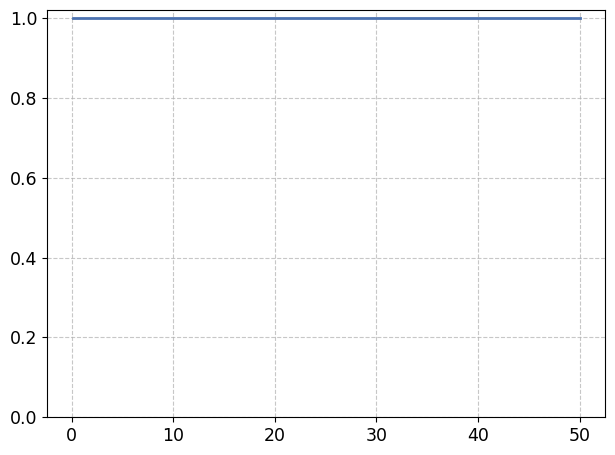

In [585]:
# plt.plot(times[1:]*1e6, p_list)
# plt.plot(times[1:]*1e6, 0.5*np.e**(times[1:]/50e-6)-0.5)
plt.plot(times[1:]*1e6, listi)
plt.ylim(0,1.02)

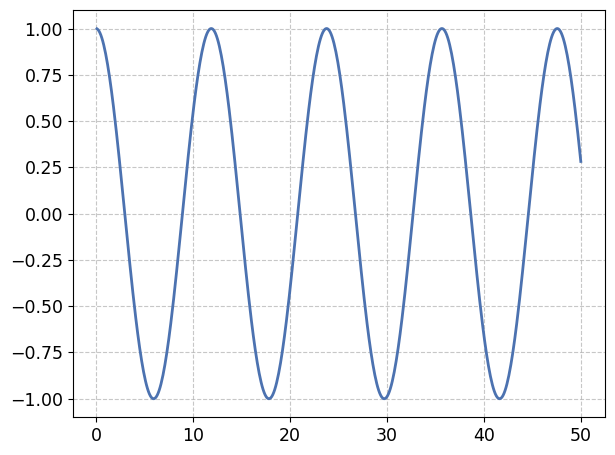

In [309]:
miri_list = np.load("Lindblad_2uT.npy")
miri_list = miri_list[:,:,1:]
times = np.linspace(0, 50e-6, 500)
PTM_list = construct_PTM(miri_list)

timesteps = PTM_list.shape[-1]
inv_PTM_list = np.zeros(PTM_list.shape)
for i in range(timesteps):
    inv_PTM_list[:,:,i] = invert_PTM(PTM_list[:,:,i])

miri_list = np.load("Lindblad_5uT.npy")
miri_list = miri_list[:,:,1:]
PTM_list = construct_PTM(miri_list)

Sz_list = []
init_state = q.fock_dm(2,0).full()
for i in range(timesteps):
    PTM = PTM_list[:,:,i]
    rho_noise = apply_ptm(PTM, init_state)
    inv_PTM = inv_PTM_list[:,:,i]
    rho_mitigated = apply_ptm(inv_PTM, rho_noise)
    Sz_list.append(q.expect(q.sigmaz(), q.Qobj(rho_mitigated)))

plt.plot(times[1:]*1e6, Sz_list)

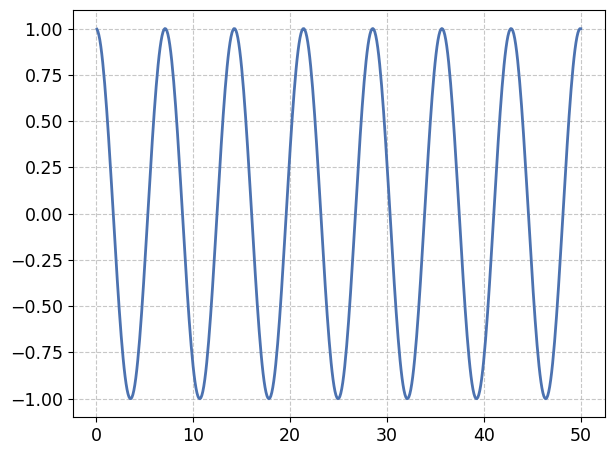

In [312]:
miri_list = np.load("Lindblad_0uT.npy")
miri_list = miri_list[:,:,1:]
times = np.linspace(0, 50e-6, 500)
PTM_list = construct_PTM(miri_list)

timesteps = PTM_list.shape[-1]
inv_PTM_list = np.zeros(PTM_list.shape)
for i in range(timesteps):
    inv_PTM_list[:,:,i] = invert_PTM(PTM_list[:,:,i])

miri_list = np.load("Lindblad_5uT.npy")
miri_list = miri_list[:,:,1:]
PTM_list = construct_PTM(miri_list)

Sz_list = []
init_state = q.fock_dm(2,0).full()
for i in range(timesteps):
    PTM = PTM_list[:,:,i]
    rho_noise = apply_ptm(PTM, init_state)
    inv_PTM = inv_PTM_list[:,:,i]
    rho_mitigated = apply_ptm(inv_PTM, rho_noise)
    Sz_list.append(q.expect(q.sigmaz(), q.Qobj(rho_mitigated)))

plt.plot(times[1:]*1e6, Sz_list)